In [1]:
#Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from config import api_key
from scipy.stats import linregress
import scipy.stats as st
import json
import requests

In [2]:
# Read the CSV file
df = pd.read_csv("Wrangled_df.csv",index_col = "Movie ID")
df.head()

,Name,Year,Score,Genre,Budget,Revenue,Language,Profit
Movie ID,,,,,,,,
0,the passion of the christ,2004,74.0,Drama,25000000.0,6.223136e+08,English,5.973136e+08
1,john wick: chapter 2,2017,73.0,"Action, Thriller, Crime",40000000.0,1.715399e+08,English,1.315399e+08
2,john wick: chapter 3 - parabellum,2019,74.0,"Action, Thriller, Crime",55000000.0,3.267097e+08,English,2.717097e+08
3,a bronx tale,1994,78.0,"Drama, Crime",10000000.0,1.728790e+07,English,7.287898e+06
4,avatar,2009,76.0,"Action, Adventure, Fantasy, Science Fiction",237000000.0,2.923706e+09,English,2.686706e+09


# Expanding Genre into multiple binary columns

In [3]:
# Initialize an empty set to store all unique genres
unique_genres = set()

# Iterate over the DataFrame rows
for index, row in df.iterrows():
    # Split the 'Genre' column by commas and add each genre to the set
    movie_genres = [genre.strip() for genre in row['Genre'].split(',')]
    unique_genres.update(movie_genres)

# Convert the set of unique genres to a list
unique_genres = list(unique_genres)

# Iterate over the DataFrame rows again to create genre columns
for index, row in df.iterrows():
    # Split the 'Genre' column by commas and create a dictionary to store genre values
    movie_genres = {genre: 1 if genre.strip() in row['Genre'] else 0 for genre in unique_genres}
    
    # Update the DataFrame row with genre values
    for genre, value in movie_genres.items():
        df.at[index, genre] = value

# Print the updated DataFrame
df.head(5)

,Name,Year,Score,Genre,Budget,Revenue,Language,Profit,Crime,Science Fiction,...,Romance,Drama,Documentary,Animation,Horror,Action,Fantasy,Mystery,Music,TV Movie
Movie ID,,,,,,,,,,,,,,,,,,,,,
0,the passion of the christ,2004,74.0,Drama,25000000.0,6.223136e+08,English,5.973136e+08,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,john wick: chapter 2,2017,73.0,"Action, Thriller, Crime",40000000.0,1.715399e+08,English,1.315399e+08,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,john wick: chapter 3 - parabellum,2019,74.0,"Action, Thriller, Crime",55000000.0,3.267097e+08,English,2.717097e+08,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,a bronx tale,1994,78.0,"Drama, Crime",10000000.0,1.728790e+07,English,7.287898e+06,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,avatar,2009,76.0,"Action, Adventure, Fantasy, Science Fiction",237000000.0,2.923706e+09,English,2.686706e+09,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


# Making a new Data Frame 

In [4]:
# Initialize lists to store data for pie chart
size = []
label = []
Genre = []
profit = []
budget = []
year = []
score =[]

# Iterate over the DataFrame rows
for index, row in df.iterrows():
    # Iterate over each genre column and check if it's 1
    for genre in unique_genres:
        if row[genre] == 1:
            # Append relevant data to lists
            label.append(row['Name'])
            size.append(row['Revenue'])  
            profit.append(row['Profit'])
            budget.append(row['Budget'])
            year.append(row['Year'])
            score.append(row['Score'])
            Genre.append(genre)
            
# Create a DataFrame from the lists
data = {'Name': label, 'Genre': Genre, 'Revenue': size, 'Profit':profit, 'Budget':budget, 'Year':year, 'Score':score}
df_genre = pd.DataFrame(data)
df_genre.head ()

,Name,Genre,Revenue,Profit,Budget,Year,Score
0,the passion of the christ,Drama,622313635.0,597313635.0,25000000.0,2004,74.0
1,john wick: chapter 2,Crime,171539887.0,131539887.0,40000000.0,2017,73.0
2,john wick: chapter 2,Thriller,171539887.0,131539887.0,40000000.0,2017,73.0
3,john wick: chapter 2,Action,171539887.0,131539887.0,40000000.0,2017,73.0
4,john wick: chapter 3 - parabellum,Crime,326709727.0,271709727.0,55000000.0,2019,74.0


# Total count of data points in each Genres

In [5]:
genre_counts = df_genre.groupby('Genre')['Revenue'].count()
genre_counts

Genre
Action             1436
Adventure          1015
Animation           654
Comedy             1666
Crime               704
Documentary          96
Drama              1823
Family              886
Fantasy             655
History             207
Horror              813
Music               158
Mystery             491
Romance             712
Science Fiction     706
TV Movie            133
Thriller           1450
War                 129
Western              51
Name: Revenue, dtype: int64

In [6]:
# Group by 'Name' to calculate the count of genres for each movie
movie_stats = df_genre.groupby('Name').agg({'Genre': 'count'}).reset_index()
movie_stats.columns = ['Name', 'Genre_count']

# Merge this genre count data back with the original DataFrame
merged_data = pd.merge(df_genre, movie_stats, on='Name')

# Calculate the mean revenue and profit for each movie, taking into account the count of genres
merged_data['Revenue_mean'] = merged_data['Revenue'] / merged_data['Genre_count']
merged_data['Profit_mean'] = merged_data['Profit'] / merged_data['Genre_count']
merged_data

,Name,Genre,Revenue,Profit,Budget,Year,Score,Genre_count,Revenue_mean,Profit_mean
0,the passion of the christ,Drama,622313635.0,597313635.0,25000000.0,2004,74.0,1,6.223136e+08,5.973136e+08
1,john wick: chapter 2,Crime,171539887.0,131539887.0,40000000.0,2017,73.0,3,5.717996e+07,4.384663e+07
2,john wick: chapter 2,Thriller,171539887.0,131539887.0,40000000.0,2017,73.0,3,5.717996e+07,4.384663e+07
3,john wick: chapter 2,Action,171539887.0,131539887.0,40000000.0,2017,73.0,3,5.717996e+07,4.384663e+07
4,john wick: chapter 3 - parabellum,Crime,326709727.0,271709727.0,55000000.0,2019,74.0,3,1.089032e+08,9.056991e+07
...,...,...,...,...,...,...,...,...,...,...
13780,darkman ii: the return of durant,Horror,475661306.0,359661306.0,116000000.0,1995,55.0,5,9.513226e+07,7.193226e+07
13781,darkman ii: the return of durant,Action,475661306.0,359661306.0,116000000.0,1995,55.0,5,9.513226e+07,7.193226e+07
13782,the swan princess: a royal wedding,Family,539401838.6,447001838.6,92400000.0,2020,70.0,3,1.798006e+08,1.490006e+08
13783,the swan princess: a royal wedding,Animation,539401838.6,447001838.6,92400000.0,2020,70.0,3,1.798006e+08,1.490006e+08


In [7]:
merged_data_df = merged_data[["Name","Year","Genre","Genre_count","Score","Budget","Revenue_mean","Profit_mean"]]
merged_data_df

,Name,Year,Genre,Genre_count,Score,Budget,Revenue_mean,Profit_mean
0,the passion of the christ,2004,Drama,1,74.0,25000000.0,6.223136e+08,5.973136e+08
1,john wick: chapter 2,2017,Crime,3,73.0,40000000.0,5.717996e+07,4.384663e+07
2,john wick: chapter 2,2017,Thriller,3,73.0,40000000.0,5.717996e+07,4.384663e+07
3,john wick: chapter 2,2017,Action,3,73.0,40000000.0,5.717996e+07,4.384663e+07
4,john wick: chapter 3 - parabellum,2019,Crime,3,74.0,55000000.0,1.089032e+08,9.056991e+07
...,...,...,...,...,...,...,...,...
13780,darkman ii: the return of durant,1995,Horror,5,55.0,116000000.0,9.513226e+07,7.193226e+07
13781,darkman ii: the return of durant,1995,Action,5,55.0,116000000.0,9.513226e+07,7.193226e+07
13782,the swan princess: a royal wedding,2020,Family,3,70.0,92400000.0,1.798006e+08,1.490006e+08
13783,the swan princess: a royal wedding,2020,Animation,3,70.0,92400000.0,1.798006e+08,1.490006e+08


# Plot the data to see data distribution

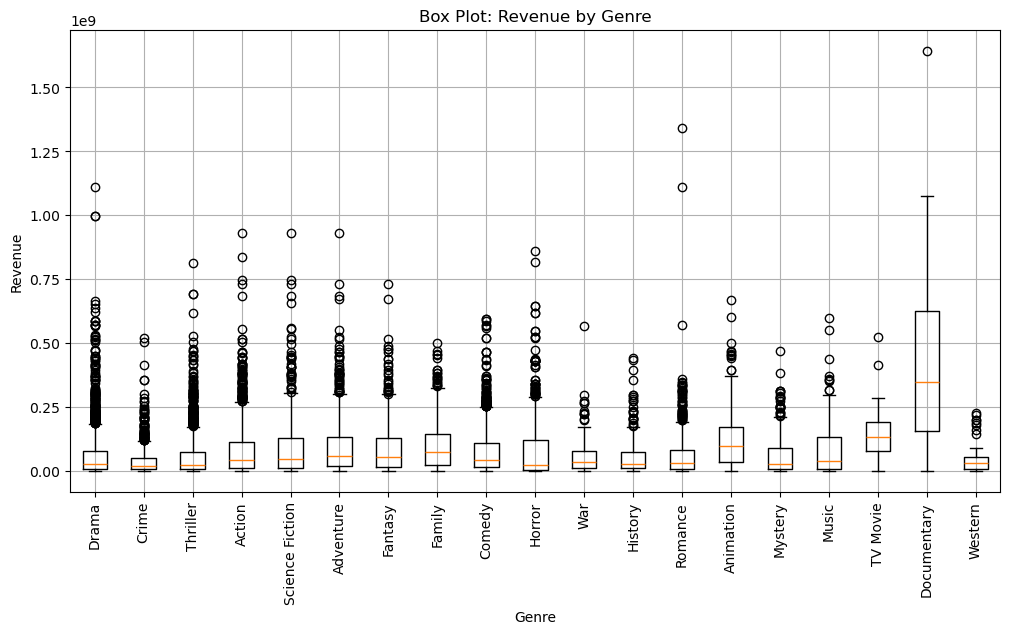

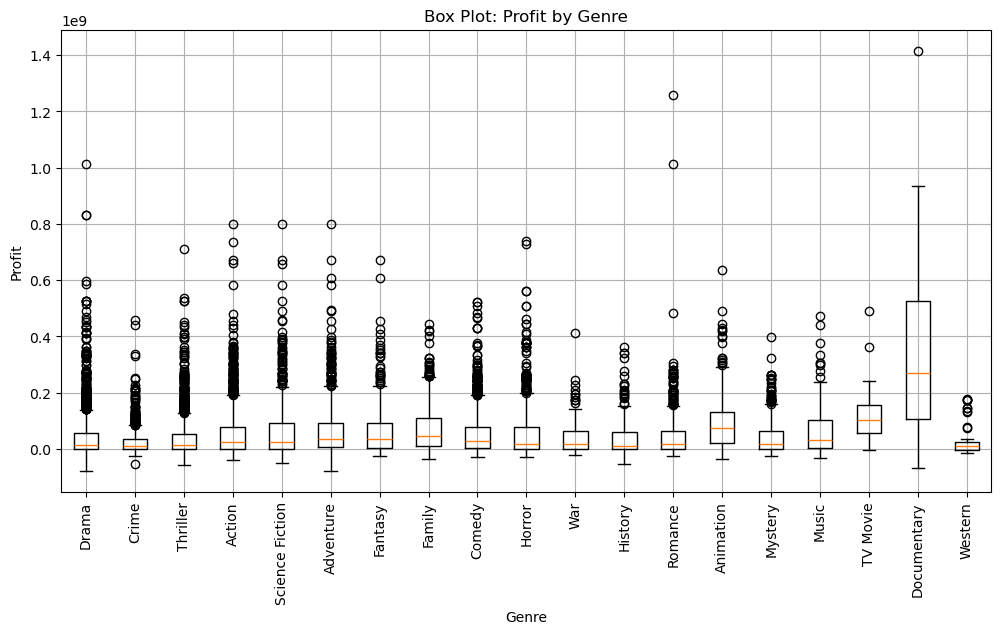

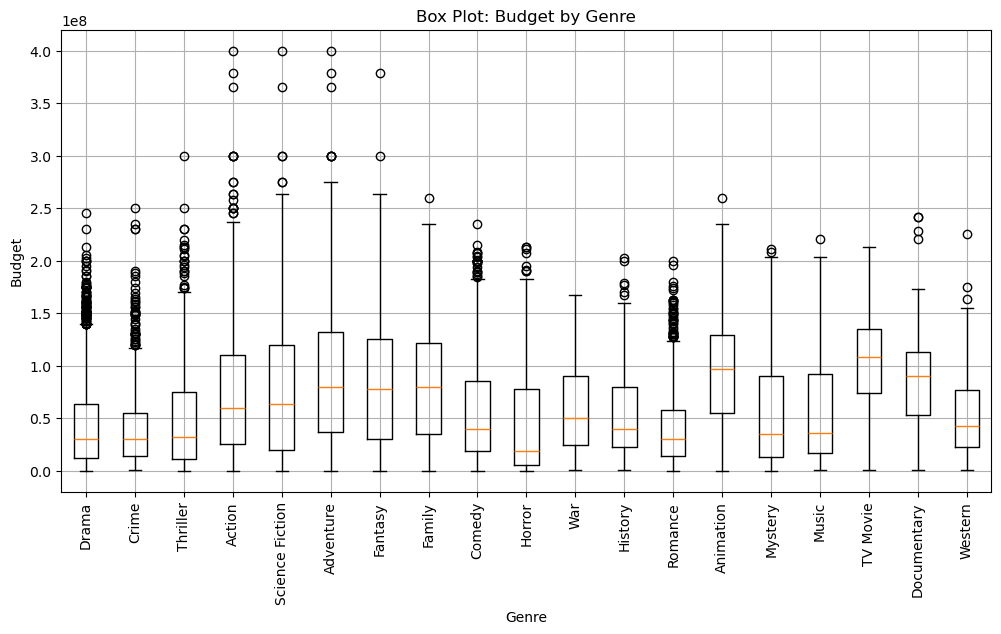

In [8]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Box plot for Revenue by Genre
plt.boxplot([merged_data_df[merged_data_df['Genre'] == genre]['Revenue_mean'] for genre in merged_data_df['Genre'].unique()], labels=merged_data_df['Genre'].unique())
plt.xlabel('Genre')
plt.ylabel('Revenue')
plt.title('Box Plot: Revenue by Genre')
plt.xticks(rotation=90)  
plt.grid(True)
plt.show()

# Set the figure size
plt.figure(figsize=(12, 6))

# Box plot for Profit by Genre
plt.boxplot([merged_data_df[merged_data_df['Genre'] == genre]['Profit_mean'] for genre in merged_data_df['Genre'].unique()], labels=merged_data_df['Genre'].unique())
plt.xlabel('Genre')
plt.ylabel('Profit')
plt.title('Box Plot: Profit by Genre')
plt.xticks(rotation=90)  
plt.grid(True)
plt.show()

# Set the figure size
plt.figure(figsize=(12, 6))

# Box plot for Budget by Genre
plt.boxplot([merged_data_df[merged_data_df['Genre'] == genre]['Budget'] for genre in merged_data_df['Genre'].unique()], labels=merged_data_df['Genre'].unique())
plt.xlabel('Genre')
plt.ylabel('Budget')
plt.title('Box Plot: Budget by Genre')
plt.xticks(rotation=90)  
plt.grid(True)
plt.show()

# Calculate statistics and outliers for revenue by genre

In [9]:
# Initialize dictionary to store outliers, mean, mode, median, and outlier count for each genre
genre_info = {}
genres = merged_data['Genre'].unique()
# Loop through each genre
for genre in genres:
    # Filter DataFrame for the current genre
    genre_data = merged_data[merged_data['Genre'] == genre]
    
    # Calculate quartiles and IQR for revenue
    quartiles = genre_data['Revenue_mean'].quantile([0.25, 0.5, 0.75])
    lower_q = quartiles[0.25]
    upper_q = quartiles[0.75]
    IQR = upper_q - lower_q
    
    # Calculate lower and upper bounds for outliers
    lower_bound = lower_q - 1.5 * IQR
    upper_bound = upper_q + 1.5 * IQR
    
    # Identify outliers for the current genre
    outliers = genre_data[(genre_data['Revenue_mean'] < lower_bound) | (genre_data['Revenue_mean'] > upper_bound)]
    
    # Store outliers and outlier count for the current genre in the dictionary
    genre_info[genre] = {
        'outliers': outliers['Revenue_mean'],
        'outlier_count': len(outliers),  
        'mean': genre_data['Revenue_mean'].mean(),
        'mode': genre_data['Revenue_mean'].mode(),
        'median': genre_data['Revenue_mean'].median(),
    }

    # Print information for the current genre
    print(f"\nGenre: {genre}")
    print(f"Lower Quartile: {lower_q}")
    print(f"Upper Quartile: {upper_q}")
    print(f"IQR: {IQR}")
    print(f"Lower Bound: {lower_bound}")
    print(f"Upper Bound: {upper_bound}")
    print(f"Outliers: {outliers['Revenue_mean']}")
    print(f"Number of Outliers: {len(outliers)}")  # Print count of outliers
    print(f"Mean: {genre_info[genre]['mean']}")
    print(f"Mode: {genre_info[genre]['mode']}")
    print(f"Median: {genre_info[genre]['median']}")

# Print information for each genre
for genre, info in genre_info.items():
    print(f"\nGenre: {genre}")
    print(f"Outliers: {info['outliers']}")
    print(f"Number of Outliers: {info['outlier_count']}")
    print(f"Mean: {info['mean']}")
    print(f"Mode: {info['mode']}")
    print(f"Median: {info['median']}")


Genre: Drama
Lower Quartile: 6330990.166666666
Upper Quartile: 77485268.16666666
IQR: 71154277.99999999
Lower Bound: -100400426.8333333
Upper Bound: 184216685.16666663
Outliers: 0        6.223136e+08
26       2.135915e+08
33       3.139256e+08
54       2.160276e+08
78       3.417728e+08
             ...     
13383    2.192237e+08
13384    4.400809e+08
13414    5.260817e+08
13614    4.423242e+08
13616    1.999508e+08
Name: Revenue_mean, Length: 182, dtype: float64
Number of Outliers: 182
Mean: 64266123.145544685
Mode: 0    583921229.0
Name: Revenue_mean, dtype: float64
Median: 23909456.5

Genre: Crime
Lower Quartile: 5597632.666666667
Upper Quartile: 50296934.833333336
IQR: 44699302.16666667
Lower Bound: -61451320.58333334
Upper Bound: 117345888.08333334
Outliers: 66       1.299387e+08
243      4.122346e+08
309      5.048512e+08
440      2.515585e+08
486      3.563739e+08
             ...     
12905    1.185828e+08
13137    1.558860e+08
13310    1.773813e+08
13659    5.208164e+08
13718

# Calculate statistics without presence of outliers for revenue by genre

In [10]:
# Define unique genres
genres = merged_data['Genre'].unique()

# Initialize dictionary to store mean, mode, and median for each genre
genre_stats = {}

# Loop through each genre
for genre in genres:
    # Filter DataFrame for the current genre
    genre_data = merged_data[merged_data['Genre'] == genre]
    
    # Calculate quartiles and IQR for revenue
    quartiles = genre_data['Revenue_mean'].quantile([0.25, 0.5, 0.75])
    lower_q = quartiles[0.25]
    upper_q = quartiles[0.75]
    IQR = upper_q - lower_q
    
    # Calculate lower and upper bounds for outliers
    lower_bound = lower_q - 1.5 * IQR
    upper_bound = upper_q + 1.5 * IQR
    
    # Filter out outliers for the current genre
    genre_data_filtered = genre_data[(genre_data['Revenue_mean'] >= lower_bound) & (genre_data['Revenue_mean'] <= upper_bound)]
    
    # Calculate mean, mode, and median for the filtered data
    mean = genre_data_filtered['Revenue_mean'].mean()
    mode = genre_data_filtered['Revenue_mean'].mode()
    median = genre_data_filtered['Revenue_mean'].median()
    
    # Store stats for the current genre in the dictionary
    genre_stats[genre] = {
        'mean': mean,
        'mode': mode,
        'median': median
    }

    # Print information for the current genre
    print(f"\nGenre: {genre}")
    print(f"Mean (without outliers): {mean}")
    print(f"Mode (without outliers): {mode}")
    print(f"Median (without outliers): {median}")

# Print information for each genre
for genre, stats in genre_stats.items():
    print(f"\nGenre: {genre}")
    print(f"Mean (without outliers): {stats['mean']}")
    print(f"Mode (without outliers): {stats['mode']}")
    print(f"Median (without outliers): {stats['median']}")


Genre: Drama
Mean (without outliers): 37182449.136955895
Mode (without outliers): 0    3.371429e+05
1    6.803835e+05
2    1.000000e+06
3    1.132429e+06
4    3.640852e+06
5    3.135991e+07
6    4.317710e+07
7    7.060080e+07
8    7.307007e+07
9    9.045642e+07
Name: Revenue_mean, dtype: float64
Median (without outliers): 19302578.0

Genre: Crime
Mean (without outliers): 25679345.458130836
Mode (without outliers): 0    1.731334e+07
Name: Revenue_mean, dtype: float64
Median (without outliers): 16068105.416666668

Genre: Thriller
Mean (without outliers): 35892434.056372724
Mode (without outliers): 0     1.336500e+03
1     4.134205e+05
2     7.549529e+05
3     8.000000e+05
4     8.568903e+06
5     1.271300e+07
6     1.906950e+07
7     3.750000e+07
8     1.039727e+08
9     1.220825e+08
10    1.323752e+08
11    1.485888e+08
12    1.595203e+08
13    1.614725e+08
Name: Revenue_mean, dtype: float64
Median (without outliers): 18207251.416666664

Genre: Action
Mean (without outliers): 61424064.

# Visual 1: Overview of Genres (Bar chart, pie chart) by sum/average(decide later) revenue & Genre by movie count

** Keep Revenue values as it is (No Division) _ Plot based on Mean

In [11]:
# Group the DataFrame by genre and calculate total revenue for each genre
genre_revenue = df_genre.groupby('Genre').agg({'Revenue': 'sum', 'Name': 'count'})
genre_revenue['Average_Revenue'] = genre_revenue['Revenue'] / genre_revenue['Name']
genre_revenue.reset_index(inplace=True)

# Three top Genres:
genre_revenue_sorted = genre_revenue.sort_values ("Revenue",ascending = False)
genre_revenue_sorted.head(5)

,Genre,Revenue,Name,Average_Revenue
0,Action,3.546686e+11,1436,2.469837e+08
3,Comedy,3.429143e+11,1666,2.058309e+08
1,Adventure,3.271453e+11,1015,3.223107e+08
6,Drama,2.823142e+11,1823,1.548624e+08
7,Family,2.805633e+11,886,3.166628e+08


In [12]:
# # Plotting the pie chart
# plt.figure(figsize=(10, 5))
# plt.pie(genre_revenue["Revenue"], labels=genre_revenue['Genre'], autopct='%1.1f%%')
# plt.legend(loc="upper right", bbox_to_anchor=(1.1, 1))
# plt.title('Revenue Distribution by Genre')
# plt.axis('equal')
# plt.show()

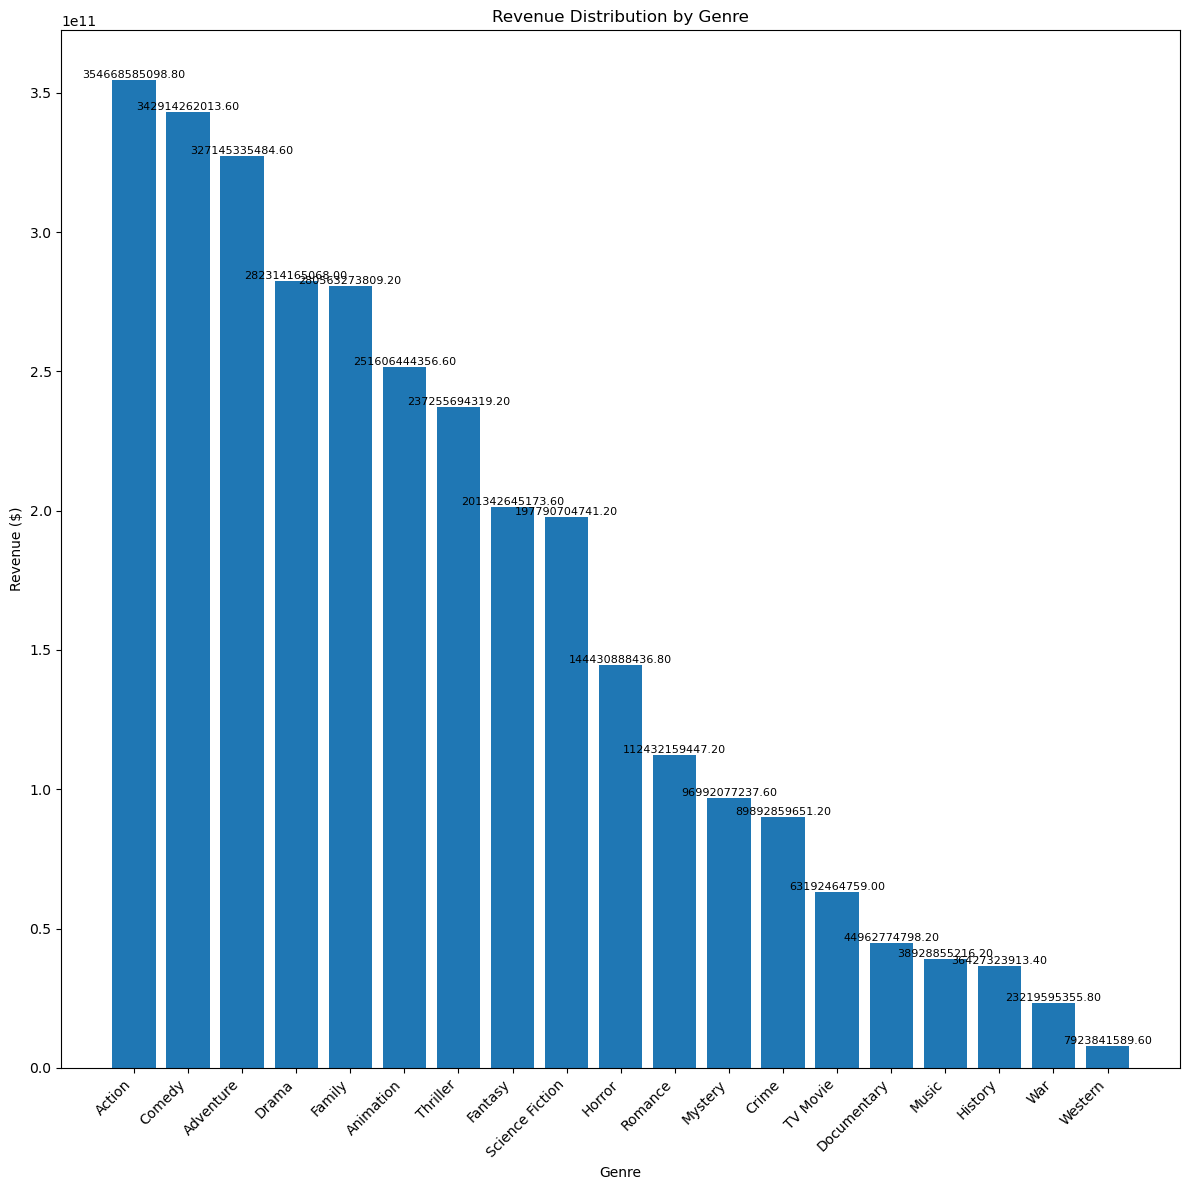

In [13]:
# Plotting the bar chart
plt.figure(figsize=(12, 12))
bars = plt.bar(genre_revenue_sorted['Genre'], genre_revenue_sorted["Revenue"], align="center")
plt.xticks(rotation=45, ha="right")
plt.xlabel('Genre')
plt.ylabel("Revenue ($)")
plt.title('Revenue Distribution by Genre')

#Annotate each bar with its value
plt.bar_label(bars, fmt='%.2f', label_type='edge', fontsize=8)
plt.tight_layout()

# Show the plot
plt.show()


** Keep Revenue values as it is (No Division) _ Plot based on Median

In [14]:
genre_revenue_median = df_genre.groupby("Genre").agg({'Revenue':'median'}).reset_index ()
genre_revenue_median_sorted = genre_revenue_median.sort_values ("Revenue", ascending = False)
genre_revenue_median_sorted.head(5)

,Genre,Revenue
15,TV Movie,470441838.0
5,Documentary,463712263.7
2,Animation,374450000.7
7,Family,261512011.5
1,Adventure,215080810.0


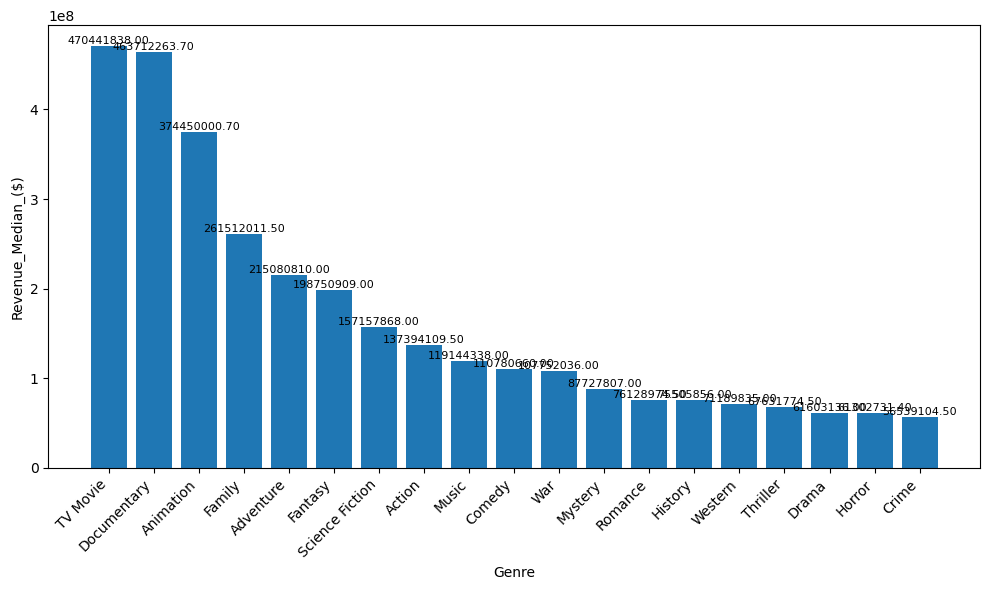

In [15]:
plt.figure(figsize=(10,6))
bars = plt.bar(genre_revenue_median_sorted["Genre"],genre_revenue_median_sorted["Revenue"],align = "center")
plt.xlabel("Genre")
plt.ylabel("Revenue_Median_($)")
plt.xticks(rotation=45, ha = "right")
plt.tight_layout()
plt.bar_label(bars, fontsize=8, fmt = "%.2f", label_type = "edge")
plt.show()


** Plot based on Revenue mean (Revenue/count of genres)_Average

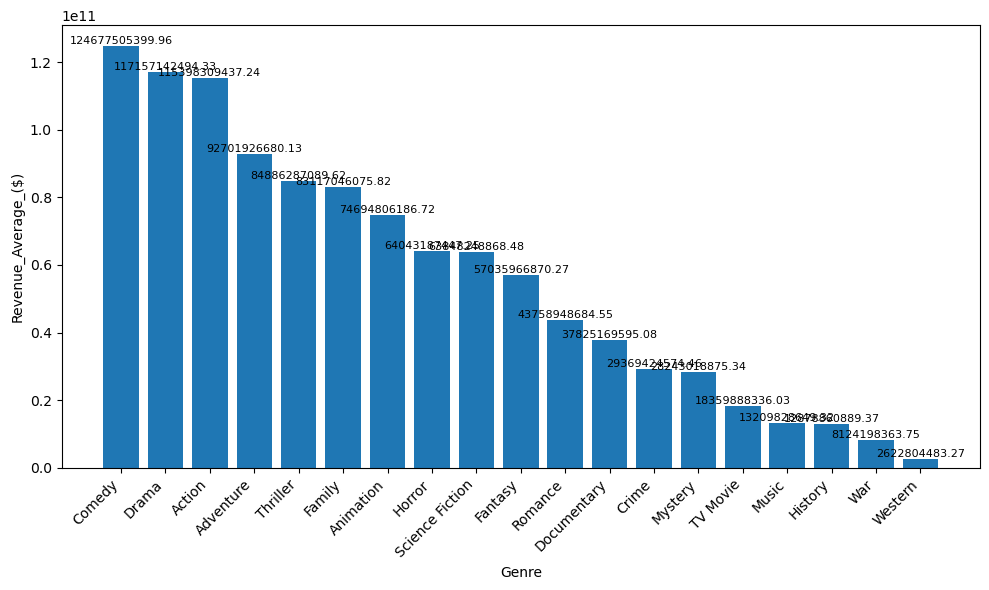

In [16]:
# genre_revenue = merged_data_df.groupby('Genre').agg({'Revenue_mean': 'mean'}).reset_index()
# genre_revenue.reset_index(inplace=True)

genre_revenue = merged_data_df.groupby('Genre').agg({'Revenue_mean': 'sum','Name':'count'})
genre_revenue['Average_Revenue'] = genre_revenue['Revenue_mean'] / genre_revenue['Name']
genre_revenue.reset_index(inplace=True)

# Three top Genres:
genre_revenue_sorted = genre_revenue.sort_values ("Revenue_mean",ascending = False)
genre_revenue_sorted.head(5)

plt.figure(figsize=(10,6))
bars = plt.bar(genre_revenue_sorted["Genre"],genre_revenue_sorted["Revenue_mean"],align = "center")
plt.xlabel("Genre")
plt.ylabel("Revenue_Average_($)")
plt.xticks(rotation=45, ha = "right")
plt.tight_layout()
plt.bar_label(bars, fontsize=8, fmt = "%.2f", label_type = "edge")
plt.show()

** Plot based on Revenue mean (Revenue/count of genres)_Median

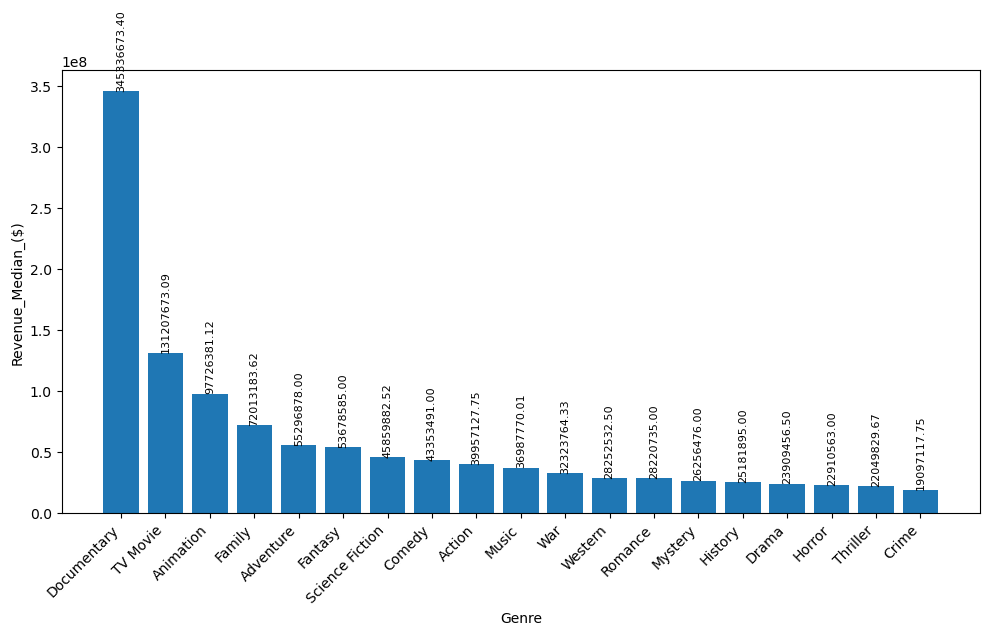

In [17]:
genre_revenue_median = merged_data_df.groupby("Genre").agg({'Revenue_mean':'median'}).reset_index ()
genre_revenue_median_sorted = genre_revenue_median.sort_values ("Revenue_mean", ascending = False)
genre_revenue_median_sorted.head(5)

plt.figure(figsize=(10,6))
bars = plt.bar(genre_revenue_median_sorted["Genre"],genre_revenue_median_sorted["Revenue_mean"],align = "center")
plt.xlabel("Genre")
plt.ylabel("Revenue_Median_($)")
plt.xticks(rotation=45, ha = "right")
plt.tight_layout()
plt.bar_label(bars, fontsize=8, fmt = "%.2f", label_type = "edge", rotation = 90)
plt.show()

# Visual 2: Breakdown by three decades

In [18]:
merged_data_df.head(5)

,Name,Year,Genre,Genre_count,Score,Budget,Revenue_mean,Profit_mean
0,the passion of the christ,2004,Drama,1,74.0,25000000.0,6.223136e+08,597313635.0
1,john wick: chapter 2,2017,Crime,3,73.0,40000000.0,5.717996e+07,43846629.0
2,john wick: chapter 2,2017,Thriller,3,73.0,40000000.0,5.717996e+07,43846629.0
3,john wick: chapter 2,2017,Action,3,73.0,40000000.0,5.717996e+07,43846629.0
4,john wick: chapter 3 - parabellum,2019,Crime,3,74.0,55000000.0,1.089032e+08,90569909.0


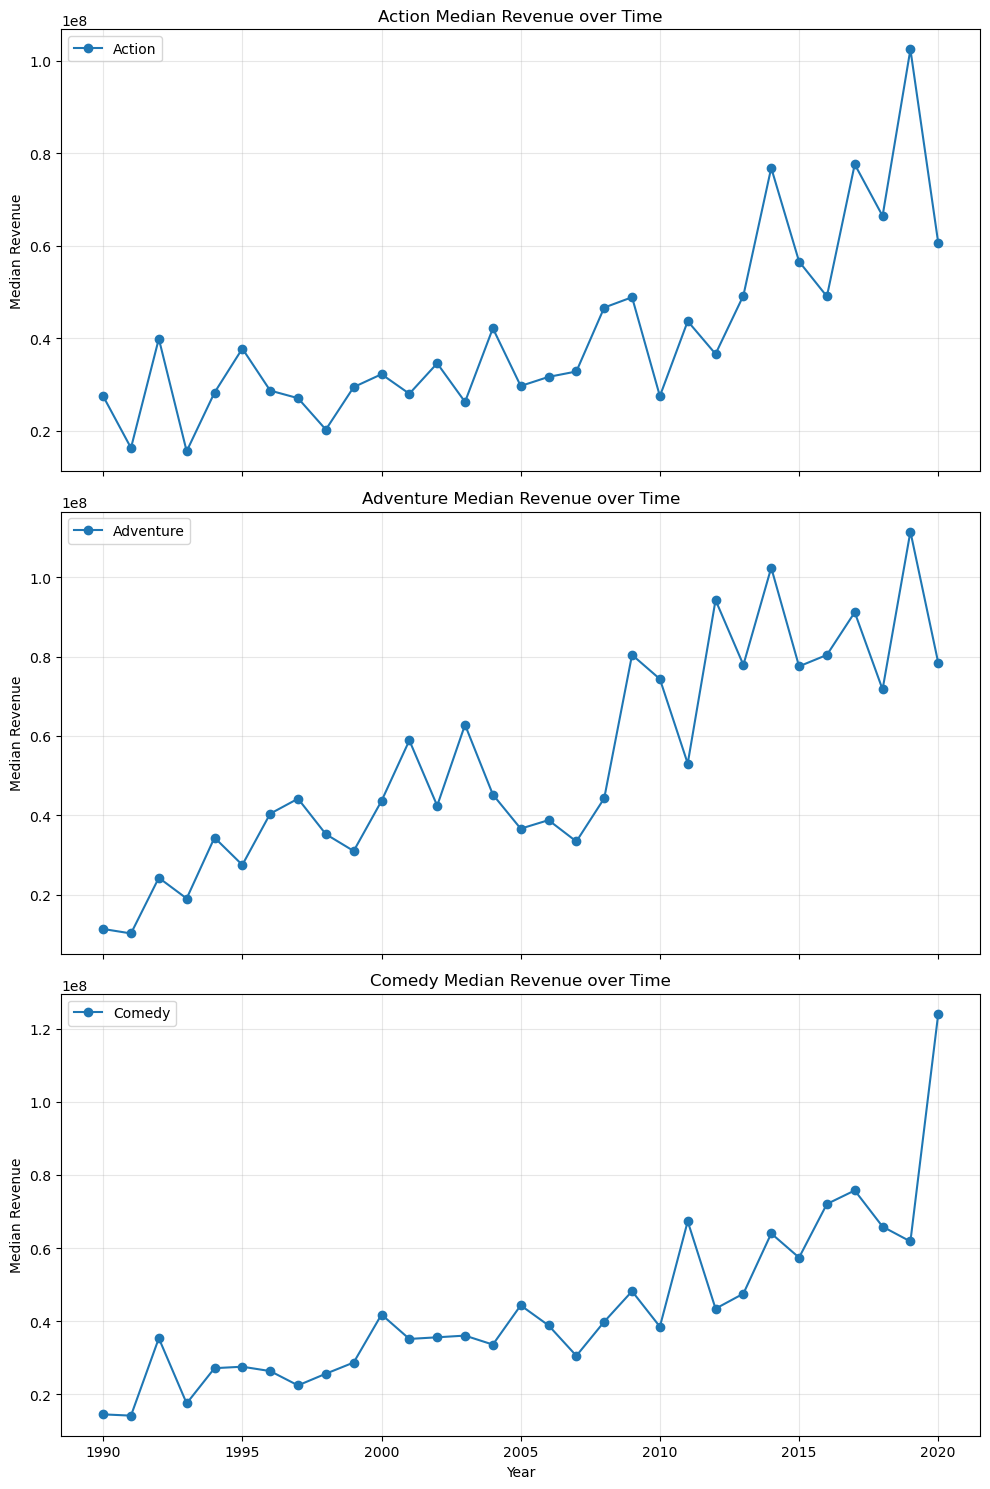

In [19]:
# Create a list of genres
genres = ['Action', 'Adventure', 'Comedy']

# merged_data_df_sorted = merged_data_df.sort_values('Revenue_mean', ascending=False)
# genres = merged_data_df_sorted.nlargest(3, 'Revenue_mean')['Genre']


# Create subplots for each genre
fig, axs = plt.subplots(len(genres), 1, figsize=(10, 15), sharex=True)

# Iterate over each genre
for i, genre in enumerate(genres):
    # Filter the DataFrame for the current genre
    df_genre_genre = merged_data_df[merged_data_df['Genre'] == genre]
    
    # Group by year and calculate the median revenue for each year
    df_median_revenue = df_genre_genre.groupby('Year')['Revenue_mean'].median().reset_index()
    
    # Plot median revenue for the current genre
    axs[i].plot(df_median_revenue['Year'], df_median_revenue['Revenue_mean'], marker='o', linestyle='-', label=genre)
    
    # Add title and labels
    axs[i].set_title(f'{genre} Median Revenue over Time')
    axs[i].set_ylabel('Median Revenue')
    axs[i].legend()
    axs[i].grid(True, alpha=0.3)

# Add common x-axis label
plt.xlabel('Year')

# Show plot
plt.tight_layout()
plt.show()

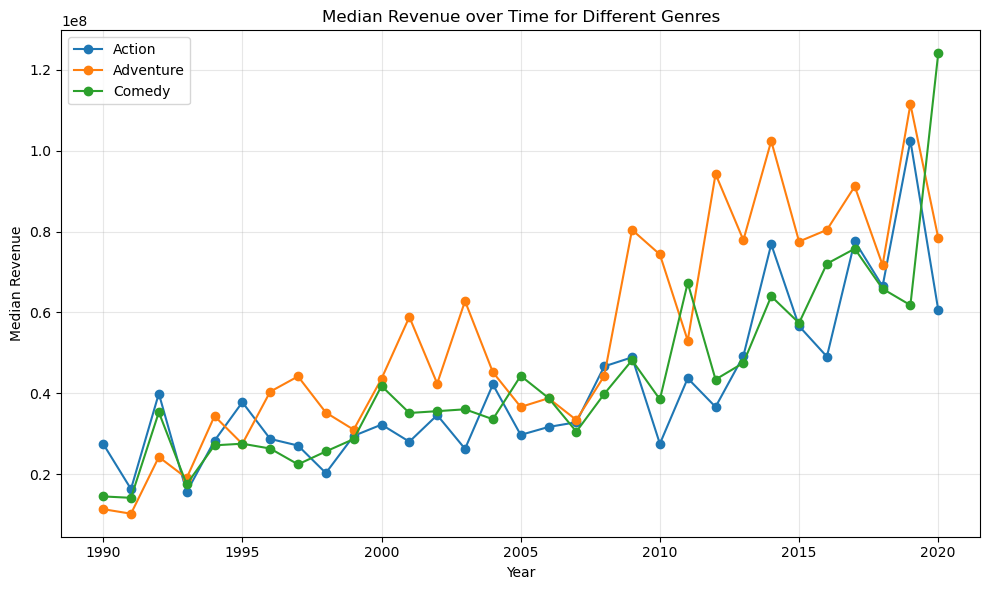

In [20]:
# Create a list of genres
genres = ['Action', 'Adventure', 'Comedy']

# Create a figure for the plot
plt.figure(figsize=(10, 6))

# Iterate over each genre
for genre in genres:
    # Filter the DataFrame for the current genre
    df_genre_genre = merged_data_df[merged_data_df['Genre'] == genre]
    
    # Group by year and calculate the median revenue for each year
    df_median_revenue = df_genre_genre.groupby('Year')['Revenue_mean'].median().reset_index()
    
    # Plot median revenue for the current genre
    plt.plot(df_median_revenue['Year'], df_median_revenue['Revenue_mean'], marker='o', linestyle='-', label=genre)

# Add title and labels
plt.title('Median Revenue over Time for Different Genres')
plt.xlabel('Year')
plt.ylabel('Median Revenue')
plt.legend()
plt.grid(True, alpha=0.3)

# Show plot
plt.tight_layout()
plt.show()

In [21]:
# Filter for selected Genres
df_genre_copy = merged_data_df.copy()
df_genre_copy["Genre"] = df_genre_copy["Genre"].str.strip().str.lower()
selected_genres = ["action", "comedy", "adventure"]
df_genre_filtered = df_genre_copy[df_genre_copy["Genre"].isin(selected_genres)]
df_genre_filtered

# Bin the "Year" column into decades
# Right=True to include the right endpoint of each bin
df_genre_filtered_copy = df_genre_filtered.copy()
Year_bins = [1990, 2000, 2010, 2020]
labels = ["1990-1999", "2000-2009", "2010-2019"]
df_genre_filtered_copy["Genre"]=df_genre_filtered_copy["Genre"].str.capitalize()
df_genre_filtered_copy ["Decade"] = pd.cut(df_genre_filtered_copy["Year"], Year_bins,labels = labels)
df_genre_profit = df_genre_filtered_copy.groupby(["Genre","Decade"],observed=False)["Profit_mean"].median().reset_index()
df_genre_profit.head(5)


,Genre,Decade,Profit_mean
0,Action,1990-1999,1.322091e+07
1,Action,2000-2009,1.928977e+07
2,Action,2010-2019,3.617158e+07
3,Adventure,1990-1999,1.658794e+07
4,Adventure,2000-2009,2.832981e+07


<Figure size 1200x600 with 0 Axes>

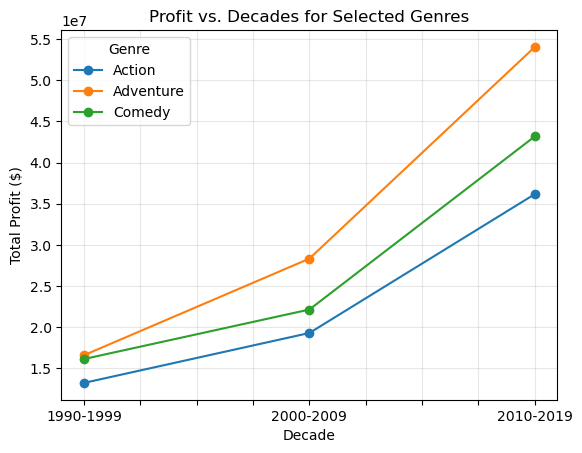

In [22]:
# Plot the profit for each genre over decades
# plt.figure(figsize=(12, 6))
# df_genre_pivot.plot(kind='line', marker='o')

# plt.title('Profit vs. Decades for Selected Genres')
# plt.xlabel('Decade')
# plt.ylabel('Total Profit ($)')
# plt.grid(True)
# plt.show()


# Pivot the DataFrame to have genres as columns
df_genre_pivot = df_genre_profit.pivot(index='Decade', columns='Genre', values='Profit_mean')

# Plot the profit for each genre over decades
plt.figure(figsize=(12, 6))
df_genre_pivot.plot(kind='line', marker='o')

plt.title('Profit vs. Decades for Selected Genres')
plt.xlabel('Decade')
plt.ylabel('Total Profit ($)')
plt.grid(True, alpha = 0.3)
plt.show()





<Figure size 1200x600 with 0 Axes>

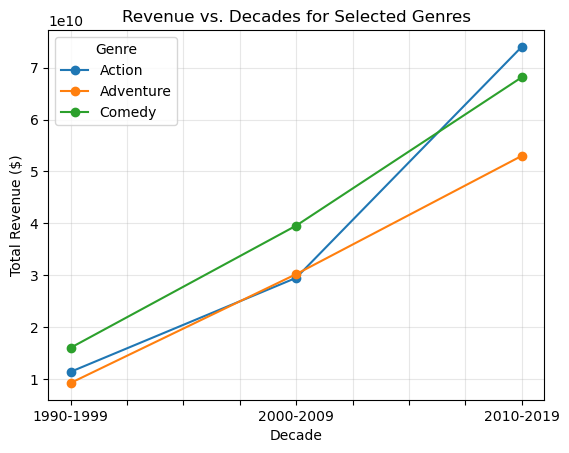

In [23]:
df_genre_revenue = df_genre_filtered_copy.groupby(["Genre","Decade"],observed=False)["Revenue_mean"].sum().reset_index()
df_genre_revenue.head(5)

df_genre_pivot = df_genre_revenue.pivot(index='Decade', columns='Genre', values='Revenue_mean')

# Plot the profit for each genre over decades
plt.figure(figsize=(12, 6))
df_genre_pivot.plot(kind='line', marker='o')

plt.title('Revenue vs. Decades for Selected Genres')
plt.xlabel('Decade')
plt.ylabel('Total Revenue ($)')
plt.grid(True, alpha = 0.3)
plt.show()

# Gross Domestic Income (GDI) vs. Box Office Revenue
** GDI represents the total income earned by individuals and businesses within a country's borders and is often used as a measure of the overall economic activity in a country.

In [ ]:
# Construct the API request URL
base_url = 'https://apps.bea.gov/api/data/'
endpoint = 'GetData'
dataset = 'REGIONAL'  
TableName = 'SAINC1'  
frequency = 'A'  # Annual data
year_range = '1990,2020'  # Desired time period (comma-delimited string)
geofips = '00000'  # National level data
parameters = {
    'UserID': api_key,
    'method': 'GetData',
    'datasetname': dataset,
    'TableName': TableName,
    'Frequency': frequency,
    'Year': year_range,
    'GeoFips': geofips,
    'ResultFormat': 'JSON'  
}

# Send API request
response = requests.get(base_url, params=parameters)
print(response.url)


In [ ]:
# Construct the API request URL
base_url = 'https://apps.bea.gov/api/data/'
endpoint = 'GetData'
dataset = 'REGIONAL'  # National Income and Product Accounts dataset
TableName = 'SAINC1'
frequency = 'A'  # Annual data
year_range = '2000'  # Desired time period (comma-delimited string)
geofips = '00000'  # National level data
LineCode = 'All'
parameters = {
    'UserID': api_key,
    'method': 'GetData',
    'datasetname': dataset,
    'TableName': TableName,
    'Frequency': frequency,
    'Year': year_range,
    'GeoFips': geofips,
    'LineCode': LineCode,
    'ResultFormat': 'JSON'  
}

# Send API request
response = requests.get(base_url, params=parameters).json()
print (json.dumps(response,indent=4,sort_keys=False))

In [ ]:
Final_df = df_genre_filtered_copy.groupby(["Genre","Year"],observed=False)[["Profit_mean","Revenue_mean","Budget"]].median().reset_index()
Final_df.head(5)

In [ ]:
# Add new columns
Final_df['Personal Income (PI)']=""
Final_df['PI UNIT MULT']=""
Final_df['Population']=""
Final_df['Population UNIT MULT']=""
Final_df.head(5)

In [ ]:
# Set the API base URL
base_url = 'https://apps.bea.gov/api/data/'

params ={ 'UserID': api_key,
    'method': 'GetData',
    'datasetname': 'REGIONAL',
    'TableName': 'SAINC1',
    'Frequency': 'A',
    'GeoFips': '00000',
    'LineCode': 'All',
    'ResultFormat': 'JSON'  
}

for i, row in Final_df.iterrows():
    year = row ["Year"]
    params["Year"]=f"{year}"
    response = requests.get(base_url, params=params).json()
    
    try:
        Final_df.loc[i,"Personal Income (PI)"] = response["BEAAPI"]["Results"]["Data"][0]["DataValue"]
        Final_df.loc[i,"PI UNIT MULT"] = response["BEAAPI"]["Results"]["Data"][0]["UNIT_MULT"]
        Final_df.loc[i,"Population"] = response["BEAAPI"]["Results"]["Data"][1]["DataValue"]
        Final_df.loc[i,"Population UNIT MULT"] = response["BEAAPI"]["Results"]["Data"][1]["UNIT_MULT"]
        
    # Broaden the exception handling to catch any exception
    except Exception as e: 
        # Print the error message
        print(f"Error processing {year}: {e.args[0]} not found")  
        Final_df.loc[i, ["Personal Income (PI)", "PI UNIT MULT", "Population", "Population UNIT MULT"]] = float("nan")
        pass

    
# Indicate that Data Loading is complete 
print("-----------------------------")
print("Data Retrieval Complete      ")
print("-----------------------------")
Final_df.head (15)

In [ ]:
Final_df["PI UNIT MULT"].nunique()

In [ ]:
Final_df.count()

In [ ]:
# Convert specific columns to numeric
Final_df['Personal Income (PI)'] = pd.to_numeric(Final_df['Personal Income (PI)'], errors='coerce')
Final_df['Population'] = pd.to_numeric(Final_df['Population'], errors='coerce')

# Drop rows with NaN values if there is any
Final_df = Final_df.dropna()
Final_df.reset_index(drop=True, inplace=True)
Final_df.count()

In [ ]:
# Define the regression plot function
def regression_plot(x_values, y_values, filename):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))
    plt.scatter(x_values, y_values)
    plt.plot(x_values, regress_values, "r-")
    x_pos = x_values.min() 
    y_pos = y_values.min() 
    plt.text(x_pos, y_pos, line_eq, fontsize=12, color="red")
    plt.xlabel(x_values.name)
    plt.ylabel(y_values.name)
    plt.title(f"{y_values.name} vs {x_values.name} for {filename}")
    plt.show()

# Define or import the correlation_plot function
def correlation_plot (x_values, y_values):
    correlation = st.pearsonr(x_values, y_values)
    print(f"The correlation between both factors is {round(correlation[0],2)}")

# Filter data for each time period
data_1990_1999 = Final_df[(Final_df['Year'] >= 1990) & (Final_df['Year'] < 2000)]
data_2000_2009 = Final_df[(Final_df['Year'] >= 2000) & (Final_df['Year'] < 2010)]
data_2010_2020 = Final_df[(Final_df['Year'] >= 2010) & (Final_df['Year'] <= 2020)]

# Extract x and y values for each time period
x_values_1990_1999 = data_1990_1999['Revenue_mean']
y_values_1990_1999 = data_1990_1999['Personal Income (PI)']
x_values_2000_2009 = data_2000_2009['Revenue_mean']
y_values_2000_2009 = data_2000_2009['Personal Income (PI)']

x_values_2010_2020 = data_2010_2020['Revenue_mean']
y_values_2010_2020 = data_2010_2020['Personal Income (PI)']

# Plot for each time period
regression_plot(x_values_1990_1999, y_values_1990_1999, "1990-2000")
regression_plot(x_values_2000_2009, y_values_2000_2009, "2000-2010")
regression_plot(x_values_2010_2020, y_values_2010_2020, "2010-2020")

# Calculate correlation coefficient for each time period
correlation_plot(x_values_1990_1999, y_values_1990_1999)
correlation_plot(x_values_2000_2009, y_values_2000_2009)
correlation_plot(x_values_2010_2020, y_values_2010_2020)

In [ ]:
# Define the regression plot function
def regression_plot(x_values, y_values, filename):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))
    plt.scatter(x_values, y_values)
    plt.plot(x_values, regress_values, "r-")
    x_pos = x_values.min() 
    y_pos = y_values.min() 
    plt.text(x_pos, y_pos, line_eq, fontsize=12, color="red")
    plt.xlabel(x_values.name)
    plt.ylabel(y_values.name)
    plt.title(f"{y_values.name} vs {x_values.name} for {filename}")
    plt.show()

# Define or import the correlation_plot function
def correlation_plot (x_values, y_values):
    correlation = st.pearsonr(x_values, y_values)
    print(f"The correlation between both factors is {round(correlation[0],2)}")

# Filter data for each time period
data_1990_1999 = Final_df[(Final_df['Year'] >= 1990) & (Final_df['Year'] < 2000)]
data_2000_2009 = Final_df[(Final_df['Year'] >= 2000) & (Final_df['Year'] < 2010)]
data_2010_2020 = Final_df[(Final_df['Year'] >= 2010) & (Final_df['Year'] <= 2020)]

# Extract x and y values for each time period
x_values_1990_1999 = data_1990_1999['Revenue_mean']
y_values_1990_1999 = data_1990_1999['Population']

x_values_2000_2009 = data_2000_2009['Revenue_mean']
y_values_2000_2009 = data_2000_2009['Population']

x_values_2010_2020 = data_2010_2020['Revenue_mean']
y_values_2010_2020 = data_2010_2020['Population']

# Plot for each time period
regression_plot(x_values_1990_1999, y_values_1990_1999, "1990-2000")
regression_plot(x_values_2000_2009, y_values_2000_2009, "2000-2010")
regression_plot(x_values_2010_2020, y_values_2010_2020, "2010-2020")

# Calculate correlation coefficient for each time period
correlation_plot(x_values_1990_1999, y_values_1990_1999)
correlation_plot(x_values_2000_2009, y_values_2000_2009)
correlation_plot(x_values_2010_2020, y_values_2010_2020)

# Disposable Personal Income Summary: Disposable Personal Income,Population, and Per Capita Disposable Personal Income

In [ ]:
# Construct the API request URL
base_url = 'https://apps.bea.gov/api/data/'
endpoint = 'GetData'
dataset = 'REGIONAL'  # National Income and Product Accounts dataset
TableName = 'SAINC51'
frequency = 'A'  # Annual data
year_range = '2000'  # Desired time period (comma-delimited string)
geofips = '00000'  # National level data
LineCode = 'All'
parameters = {
    'UserID': api_key,
    'method': 'GetData',
    'datasetname': dataset,
    'TableName': TableName,
    'Frequency': frequency,
    'Year': year_range,
    'GeoFips': geofips,
    'LineCode': LineCode,
    'ResultFormat': 'JSON'  
}

# Send API request
response = requests.get(base_url, params=parameters).json()
print (json.dumps(response,indent=4,sort_keys=False))